In [1]:
## Importing required libraries
import pandas as pd ## For DataFrame operation
import numpy as np ## Numerical python for matrix operations
from sklearn.model_selection import KFold, train_test_split ## Creating cross validation sets
from sklearn import metrics ## For loss functions
import matplotlib.pyplot as plt

## Libraries for Classification algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier
import xgboost as xgb 
import lightgbm as lgb 

C:\Users\Architect_shwet\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import itertools
%matplotlib inline

In [3]:
train = pd.read_csv('balanced_train.csv')

In [4]:
train.shape

(1000000, 26)

In [5]:
X = train.copy()

In [6]:
train.loc[ train.is_churn == 'no_churn', 'is_churn'] = 0
train.loc[ train.is_churn == 'churn', 'is_churn'] = 1

In [7]:
train['is_churn'] = train['is_churn'].astype(int)

In [8]:
X = X.drop('is_churn', axis = 1)
X = X.drop('amt_per_day', axis = 1)

In [9]:
y = train['is_churn']

In [10]:
def holdout_cv(X,y,size = 0.3, seed = 1):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = size, random_state = seed)
    return X_train, X_test, y_train, y_test

In [11]:
X_train, X_test, y_train, y_test = holdout_cv(X, y, size = 0.3, seed = 1)

In [28]:
X_test.head(1)

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,is_cancel,city,bd,gender,...,expire_year,registration_month,registration_year,discount,is_discount,membership_duration,autorenew_._not_cancel,notAutorenew_._cancel,registration_duration,reg_mem_duration
276826,293341,40,30,149,149,1,0,6,26,1,...,2015,8,2012,0,0,29,1,1,1051,1022


In [29]:
y_test.head(1)

276826    0
Name: is_churn, dtype: int32

In [24]:
X_test_just_1= X_test.head(1)
y_test_just_1= y_test.head(1)

In [30]:
X_test_just_1

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,is_cancel,city,bd,gender,...,expire_year,registration_month,registration_year,discount,is_discount,membership_duration,autorenew_._not_cancel,notAutorenew_._cancel,registration_duration,reg_mem_duration
276826,293341,40,30,149,149,1,0,6,26,1,...,2015,8,2012,0,0,29,1,1,1051,1022


In [25]:
y_test_just_1

276826    0
Name: is_churn, dtype: int32

In [26]:
check1 = model_dt.predict(X_test_just_1)

In [27]:
check1

array([0])

In [12]:
### 2) Cross-Validation (K-Fold)
def kfold_cv(X,n_folds = 5, seed = 1):
    cv = KFold(n_splits = n_folds, random_state = seed, shuffle = True)
    return cv.split(X)

XGBoost on the other hand make splits upto the max_depth specified and then start pruning the tree backwards and remove splits beyond which there is no positive gain. Another advantage is that sometimes a split of negative loss say -2 may be followed by a split of positive loss +10 But XGBoost will go deeper and it will see a combined effect of +8 of the split and keep both.

XGBoost allows user to run a cross-validation at each iteration of the boosting process and thus it is easy to get the exact optimum number of boosting iterations in a single run.

XGBoost allow users to define custom optimization objectives and evaluation criteria.

In [33]:
### Running Xgboost
def runXGB(train_X, train_y, test_X, test_y, seed_val=0, rounds=500, dep=8, eta=0.05,sub_sample=0.7,col_sample=0.7,
           min_child_weight_val=1, silent_val = 1):
    params = {}
    params["objective"] = "binary:logistic"
    params['eval_metric'] = 'auc'
    params["eta"] = eta
    params["subsample"] = sub_sample
    params["min_child_weight"] = min_child_weight_val
    params["colsample_bytree"] = col_sample
    params["max_depth"] = dep
    params["silent"] = silent_val
    params["seed"] = seed_val
    #params["max_delta_step"] = 2
    #params["gamma"] = 0.5
    num_rounds = rounds

    plst = list(params.items())
    xgtrain = xgb.DMatrix(train_X, label=train_y)


    xgtest = xgb.DMatrix(test_X, label=test_y)
    watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
    model = xgb.train(plst, xgtrain, num_rounds, watchlist, 
                          early_stopping_rounds=100, verbose_eval=20)
    
    pred_test_y = model.predict(xgtest, ntree_limit=model.best_ntree_limit)
    
    loss = 0
    loss = metrics.roc_auc_score(test_y, pred_test_y)
    return pred_test_y, loss, model
 

In [50]:
pred_test_y_xg , loss_xg, model_xg = runXGB(X_train,y_train, X_test , y_test)

[0]	train-auc:0.758693	test-auc:0.758807
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 100 rounds.
[20]	train-auc:0.780568	test-auc:0.779389
[40]	train-auc:0.786232	test-auc:0.784468
[60]	train-auc:0.790676	test-auc:0.788175
[80]	train-auc:0.794783	test-auc:0.791536
[100]	train-auc:0.800576	test-auc:0.796646
[120]	train-auc:0.806919	test-auc:0.802012
[140]	train-auc:0.81171	test-auc:0.80612
[160]	train-auc:0.816419	test-auc:0.810298
[180]	train-auc:0.820747	test-auc:0.814154
[200]	train-auc:0.824516	test-auc:0.817371
[220]	train-auc:0.828959	test-auc:0.821192
[240]	train-auc:0.832372	test-auc:0.824233
[260]	train-auc:0.835016	test-auc:0.826424
[280]	train-auc:0.83834	test-auc:0.82932
[300]	train-auc:0.841371	test-auc:0.831858
[320]	train-auc:0.845199	test-auc:0.835296
[340]	train-auc:0.847808	test-auc:0.837598
[360]	train-auc:0.850585	test-auc:0.840139
[380]	train-auc:0.853122	test-auc:0.842297
[400]	tr

In [33]:
#pred_test_y_xg
accuracy_score(y_test, pred_test_y_xg)

0.76178333333333337

In [26]:
clas = np.array(['churn','not_churn'])
clas

array(['churn', 'not_churn'], 
      dtype='<U9')

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("extra tree Normalized confusion matrix")
    else:
        print('extra tree Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, pred_test_y_xg)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=clas,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=clas, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [57]:
for i in range(len(pred_test_y_xg)):
    if pred_test_y_xg[i] >= 0.5:
       pred_test_y_xg[i] = 1
    else:
        pred_test_y_xg[i] = 0

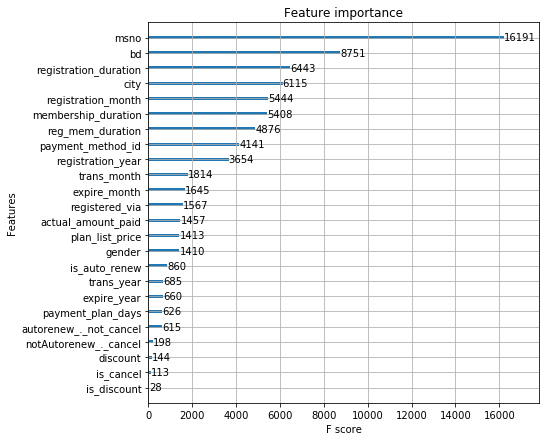

In [44]:
plt.rcParams['figure.figsize'] = (7.0, 7.0)
xgb.plot_importance(booster=model_xg); plt.show()

In [15]:
X_imp = X.copy()

In [16]:
X_imp = X_imp.drop(['is_discount', 'is_cancel'], axis = 1)

In [17]:
X_train, X_test, y_train, y_test = holdout_cv(X_imp, y, size = 0.3, seed = 1)

In [17]:
pred_test_y_xg , loss_xg, model_xg = runXGB(X_train,y_train, X_test , y_test)

[0]	train-auc:0.758693	test-auc:0.758807
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 100 rounds.
[20]	train-auc:0.780568	test-auc:0.779389
[40]	train-auc:0.786232	test-auc:0.784468
[60]	train-auc:0.790676	test-auc:0.788175
[80]	train-auc:0.794783	test-auc:0.791536
[100]	train-auc:0.800576	test-auc:0.796646
[120]	train-auc:0.806919	test-auc:0.802012
[140]	train-auc:0.81171	test-auc:0.80612
[160]	train-auc:0.816419	test-auc:0.810298
[180]	train-auc:0.820747	test-auc:0.814154
[200]	train-auc:0.824516	test-auc:0.817371
[220]	train-auc:0.828959	test-auc:0.821192
[240]	train-auc:0.832372	test-auc:0.824233
[260]	train-auc:0.835016	test-auc:0.826424
[280]	train-auc:0.83834	test-auc:0.82932
[300]	train-auc:0.841371	test-auc:0.831858
[320]	train-auc:0.845199	test-auc:0.835296
[340]	train-auc:0.847808	test-auc:0.837598
[360]	train-auc:0.850585	test-auc:0.840139
[380]	train-auc:0.853122	test-auc:0.842297
[400]	tr

In [37]:
accuracy_score(y_test, pred_test_y_xg)

0.76239333333333337

In [55]:
y_test.unique()

array([0, 1], dtype=int64)

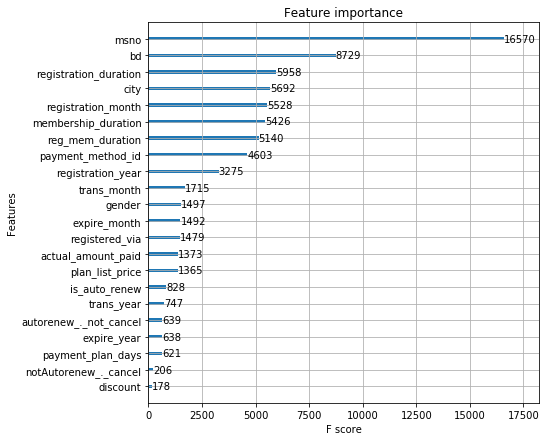

In [56]:
plt.rcParams['figure.figsize'] = (7.0, 7.0)
xgb.plot_importance(booster=model_xg); plt.show()

In [57]:
X_imp = X_imp.drop(['discount', 'notAutorenew_._cancel'], axis = 1)

In [58]:
X_train, X_test, y_train, y_test = holdout_cv(X_imp, y, size = 0.3, seed = 1)

In [51]:
pred_test_y_xg , loss_xg, model_xg = runXGB(X_train,y_train, X_test , y_test)

[0]	train-auc:0.758693	test-auc:0.758807
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 100 rounds.
[20]	train-auc:0.780568	test-auc:0.779389
[40]	train-auc:0.786232	test-auc:0.784468
[60]	train-auc:0.790676	test-auc:0.788175
[80]	train-auc:0.794783	test-auc:0.791536
[100]	train-auc:0.800576	test-auc:0.796646
[120]	train-auc:0.806919	test-auc:0.802012
[140]	train-auc:0.81171	test-auc:0.80612
[160]	train-auc:0.816419	test-auc:0.810298
[180]	train-auc:0.820747	test-auc:0.814154
[200]	train-auc:0.824516	test-auc:0.817371
[220]	train-auc:0.828959	test-auc:0.821192
[240]	train-auc:0.832372	test-auc:0.824233
[260]	train-auc:0.835016	test-auc:0.826424
[280]	train-auc:0.83834	test-auc:0.82932
[300]	train-auc:0.841371	test-auc:0.831858
[320]	train-auc:0.845199	test-auc:0.835296
[340]	train-auc:0.847808	test-auc:0.837598
[360]	train-auc:0.850585	test-auc:0.840139
[380]	train-auc:0.853122	test-auc:0.842297
[400]	tr

In [58]:
accuracy_score(y_test, pred_test_y_xg)

0.76239333333333337

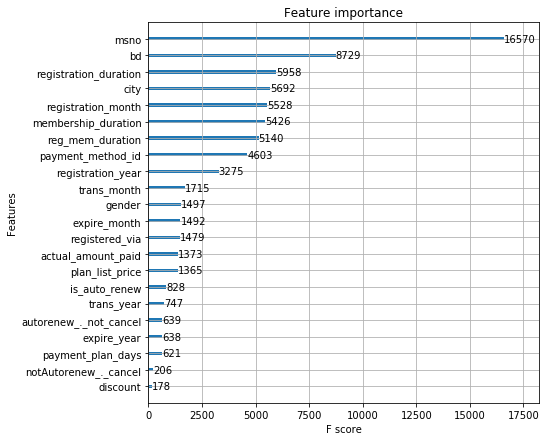

In [39]:
plt.rcParams['figure.figsize'] = (7.0, 7.0)
xgb.plot_importance(booster=model_xg); plt.show()

extra tree Confusion matrix, without normalization
[[126922  23207]
 [ 48075 101796]]
extra tree Normalized confusion matrix
[[ 0.85  0.15]
 [ 0.32  0.68]]


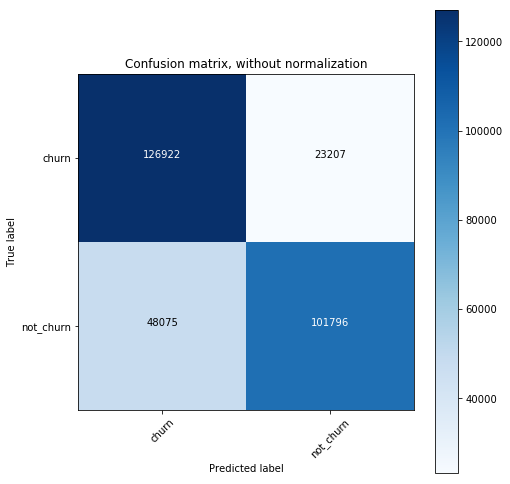

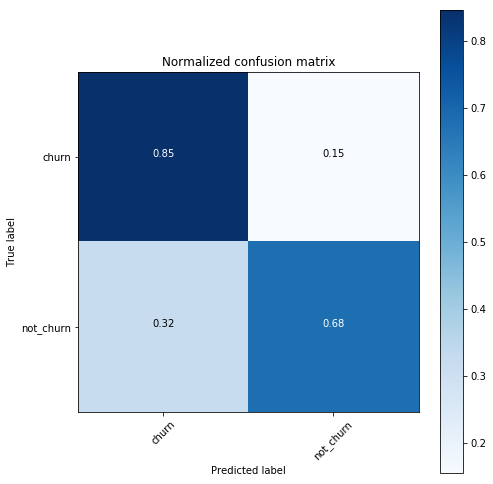

In [40]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("extra tree Normalized confusion matrix")
    else:
        print('extra tree Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, pred_test_y_xg)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=clas,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=clas, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [59]:
xg_roc = roc_auc_score(y_test, pred_test_y_xg)
xg_fpr, xg_tpr, thresholds = roc_curve(y_test, pred_test_y_xg)

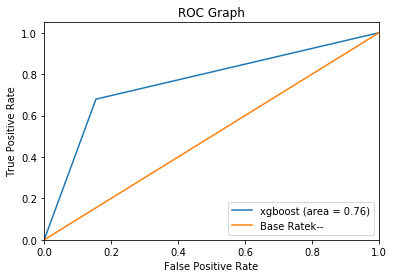

In [60]:
plt.figure()
plt.plot(xg_fpr, xg_tpr, label='xgboost (area = %0.2f)' % xg_roc)

# Plot Base Rate ROC
plt.plot([0,1], [0,1],label='Base Rate' 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Graph')
plt.legend(loc="lower right")
plt.show()

In [18]:
def feature_importance(model,X):
    feature_importance = model.feature_importances_
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5
    plt.figure(figsize=(15, 15))
    plt.subplot(1, 2, 2)
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, X.columns[sorted_idx])
    plt.xlabel('Relative Importance')
    plt.title('Variable Importance')
    plt.show()

In [19]:
### Running Random Forest
def runRF(train_X, train_y, test_X, test_y, depth=20, leaf=10, feat=0.2):
    model = RandomForestClassifier(
            n_estimators = 1000,
                    max_depth = depth,
                    min_samples_split = 2,
                    min_samples_leaf = leaf,
                    max_features =  feat,
                    n_jobs = 4,
                    random_state = 0)
    model.fit(train_X, train_y)
    train_preds = model.predict_proba(train_X)[:,1]
    test_preds = model.predict_proba(test_X)[:,1]
    
    test_loss = 0
    
    train_loss = metrics.roc_auc_score(train_y, train_preds)
    test_loss = metrics.roc_auc_score(test_y, test_preds)
    print("Train and Test loss : ", train_loss, test_loss)
    return test_preds, test_loss, model

In [20]:
test_pred_rf, loss_rf, model_rf = runRF(X_train, y_train, X_test, y_test)

Train and Test loss :  0.896972803013 0.860882024975


In [21]:
test_pred_rf

array([ 0.42905076,  0.8325595 ,  0.37390269, ...,  0.18738722,
        0.40389426,  0.8949295 ])

In [24]:
for i in range(len(test_pred_rf)):
    if test_pred_rf[i] >= 0.5:
       test_pred_rf[i] = 1
    else:
       test_pred_rf[i] = 0

In [25]:
accuracy_score(y_test, test_pred_rf)

0.76289333333333331

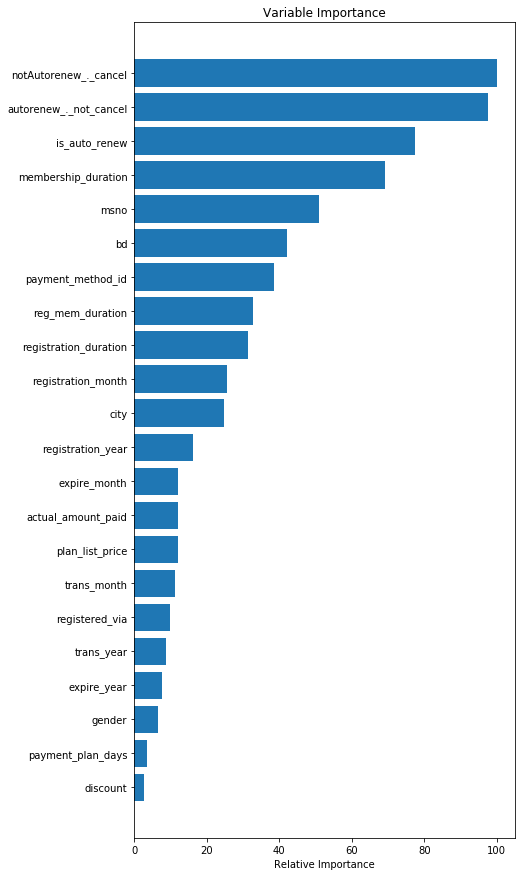

In [32]:
feature_importance(model_rf,X_train)

extra tree Confusion matrix, without normalization
[[129016  21113]
 [ 50019  99852]]
extra tree Normalized confusion matrix
[[ 0.86  0.14]
 [ 0.33  0.67]]


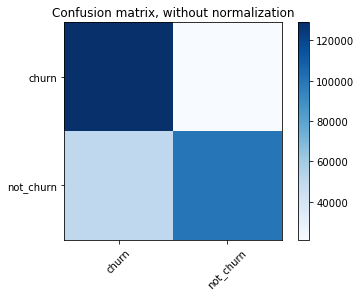

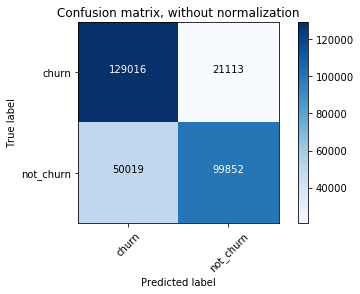

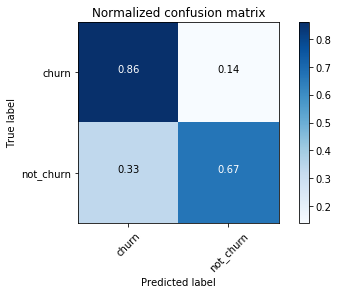

In [31]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("extra tree Normalized confusion matrix")
    else:
        print('extra tree Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, test_pred_rf)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=clas,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=clas, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [42]:
from sklearn.metrics import roc_auc_score
rf_roc = roc_auc_score(y_test,test_pred_rf )

In [43]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, model_rf.predict_proba(X_test)[:,1])

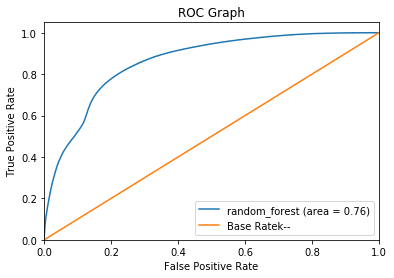

In [48]:
plt.figure()
plt.plot(fpr, tpr, label='random_forest (area = %0.2f)' % rf_roc)

# Plot Base Rate ROC
plt.plot([0,1], [0,1],label='Base Rate' 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Graph')
plt.legend(loc="lower right")
plt.show()

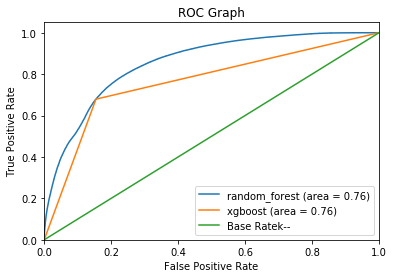

In [61]:
plt.figure()
plt.plot(fpr, tpr, label='random_forest (area = %0.2f)' % rf_roc)
plt.plot(xg_fpr, xg_tpr, label='xgboost (area = %0.2f)' % xg_roc)
# Plot Base Rate ROC
plt.plot([0,1], [0,1],label='Base Rate' 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Graph')
plt.legend(loc="lower right")
plt.show()

In [13]:
### Running Decision Tree
def runDT(train_X, train_y, test_X, test_y, criterion='gini', depth=None, min_split=2, min_leaf=1):
    model = DecisionTreeClassifier(criterion = criterion, max_depth = depth, 
                                   min_samples_split = min_split, min_samples_leaf=min_leaf)
    model.fit(train_X, train_y)
    train_preds = model.predict_proba(train_X)[:,1]
    test_preds = model.predict_proba(test_X)[:,1]
    
    test_loss = 0
    
    train_loss = metrics.roc_auc_score(train_y, train_preds)
    test_loss = metrics.roc_auc_score(test_y, test_preds)
    print("Train and Test loss : ", train_loss, test_loss)
    return test_preds, test_loss, model

In [14]:
test_pred_dt, loss_dt, model_dt = runDT( X_train, y_train, X_test, y_test)

Train and Test loss :  1.0 0.909295466915


In [15]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("decision tree Normalized confusion matrix")
    else:
        print('decision tree Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, test_pred_rf)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=clas,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=clas, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

NameError: name 'test_pred_rf' is not defined

In [68]:
test_pred_dt

array([ 0.,  1.,  1., ...,  0.,  0.,  1.])

In [17]:
dt_roc = roc_auc_score(y_test,model_dt.predict_proba(X_test)[:,1])

NameError: name 'roc_auc_score' is not defined

In [70]:
dt_fpr, dt_tpr, thresholds = roc_curve(y_test, model_dt.predict_proba(X_test)[:,1])

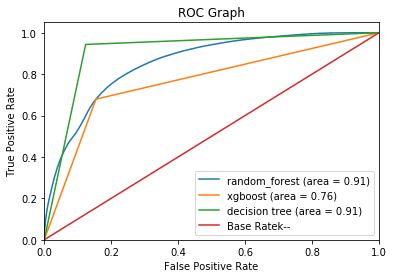

In [71]:
plt.figure()
plt.plot(fpr, tpr, label='random_forest (area = %0.2f)' % rf_roc)
plt.plot(xg_fpr, xg_tpr, label='xgboost (area = %0.2f)' % xg_roc)
plt.plot(dt_fpr, dt_tpr, label='decision tree (area = %0.2f)' % dt_roc)
# Plot Base Rate ROC
plt.plot([0,1], [0,1],label='Base Rate' 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Graph')
plt.legend(loc="lower right")
plt.show()